# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch._dynamo
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
from torch.utils.data import Dataset, DataLoader

In [2]:
sns.set_theme(style="darkgrid")

# Data preprocessing

In [3]:
column_names = ['classification'] + [f'llq_{i}' for i in range(1, 22)]+ [f'hlq_{i}' for i in range(22, 29)]
data = pd.read_csv("HIGGS_8K.csv", names=column_names)
data = data.apply(pd.to_numeric, errors='coerce')

low_X = data.iloc[:,0:22]
high_X = data.iloc[:,22:]

signal = data['classification']
signal.describe()

count    8001.000000
mean        0.523935
std         0.499458
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: classification, dtype: float64

## Low outliers Interquantile range

In [4]:
Q1 = np.percentile(low_X, 25, axis=0)
Q3 = np.percentile(low_X, 75, axis=0)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = ((low_X < lower_bound) | (low_X > upper_bound))

# Count how many features are outliers in each row
row_outliers = np.sum(outlier_mask, axis=1)

mask = row_outliers < 2

lowX_clean = low_X[mask]
lowy_clean = signal[mask]

## High Interquantile range

In [5]:
Q1 = np.percentile(high_X, 25, axis=0)
Q3 = np.percentile(high_X, 75, axis=0)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = ((high_X < lower_bound) | (high_X > upper_bound))

# Count how many features are outliers in each row
row_outliers = np.sum(outlier_mask, axis=1)

mask = row_outliers < 2

highX_clean = high_X[mask]
highy_clean = signal[mask]
highX_clean

,hlq_22,hlq_23,hlq_24,hlq_25,hlq_26,hlq_27,hlq_28
0,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,0.859235,0.827233,0.995416,0.764766,0.520597,0.850413,0.929865
2,0.887944,0.924601,0.987189,0.854094,0.385013,0.789912,0.724627
3,0.936186,1.107217,0.983808,0.693327,0.562045,0.825387,0.846233
4,1.181790,1.033701,0.993943,0.648399,0.936097,0.732592,0.661779
...,...,...,...,...,...,...,...
7994,0.939019,0.800024,1.097309,0.702681,0.125771,0.554752,0.714556
7995,0.769547,0.822408,0.982667,1.045044,0.578029,0.801592,0.814806
7996,0.566228,1.016260,0.983104,0.587913,0.661417,0.670422,0.641382
7997,0.926674,1.004506,0.983705,1.954265,0.962375,1.358500,1.227740


# Data Visualization

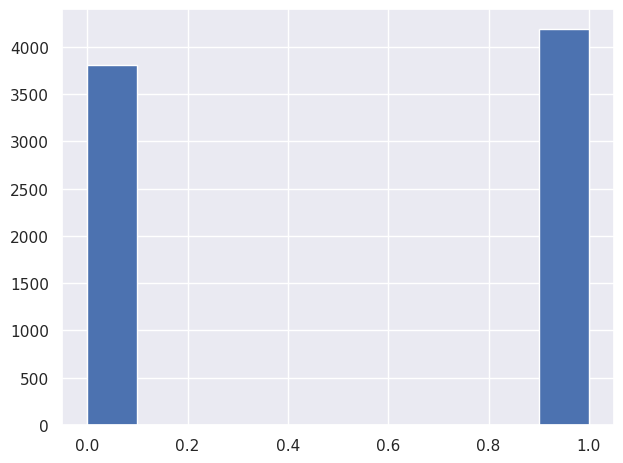

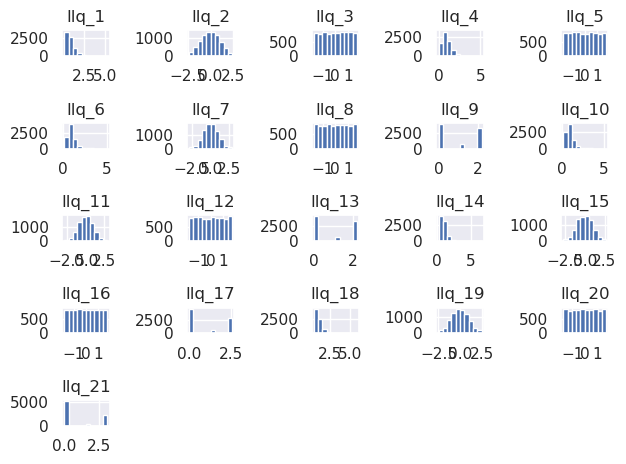

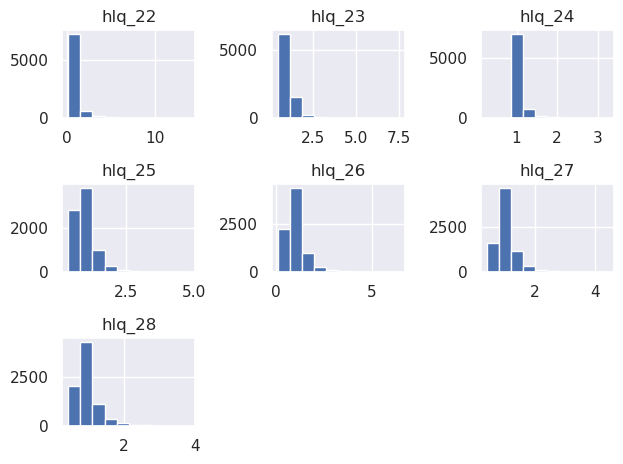

In [6]:
signal.hist()

plt.tight_layout()
plt.show()

data.iloc[:, 1:22].hist()
plt.tight_layout()
plt.show()

data.iloc[:, 22:].hist()
plt.tight_layout()
plt.show()

Removed variables due to high correlation: {'hlq_27'}


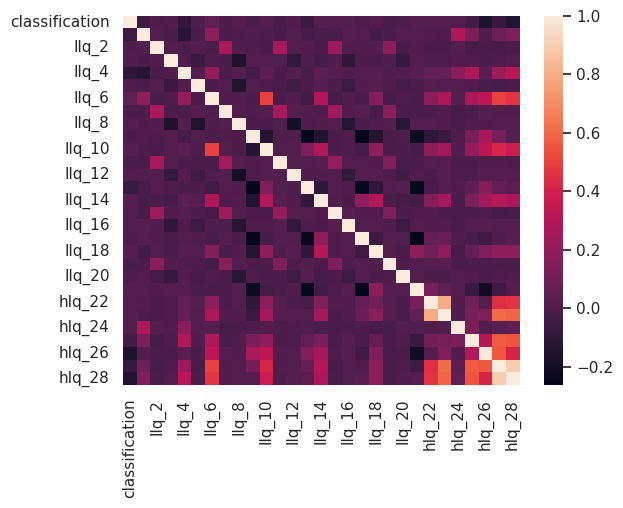

In [7]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=False)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
filtered_corr = corr_matrix.mask(mask)

threshold = 0.8

high_corr_pairs = filtered_corr.abs().stack()
to_drop = set()

for (col1, col2), corr_value in high_corr_pairs.items():
    if corr_value > threshold:
        to_drop.add(col2)

print("Removed variables due to high correlation:", to_drop)

data_filtered = data.drop(columns=list(to_drop))

In [8]:
lowX_clean = lowX_clean.to_numpy()
highX_clean = highX_clean.to_numpy()
lowy_clean = lowy_clean.to_numpy()
highy_clean = highy_clean.to_numpy()

lowX_train, lowX_test, lowy_train, lowy_test = train_test_split(lowX_clean, lowy_clean, test_size=0.2, random_state=42)
highX_train, highX_test, highy_train, highy_test = train_test_split(highX_clean, highy_clean, test_size=0.2, random_state=42)

# ANN

# Pytorch

In [9]:
scaler = StandardScaler()
lowX_train = scaler.fit_transform(lowX_train)
lowX_test = scaler.transform(lowX_test)
highX_train = scaler.fit_transform(highX_train)
highX_test = scaler.transform(highX_test)

lowX_train = np.nan_to_num(lowX_train, nan=0.0)
lowX_test = np.nan_to_num(lowX_test, nan=0.0)

highX_train = np.nan_to_num(highX_train, nan=0.0)
highX_test = np.nan_to_num(highX_test, nan=0.0)

print(np.isnan(lowX_train).any(), np.isinf(lowX_train).any())
print(np.max(lowX_train), np.min(lowX_train))


False False
10.605512687101964 -2.986461280192273


In [10]:
lowX_train  = torch.from_numpy(lowX_train).float()
lowX_test = torch.from_numpy(lowX_test).float()
highX_train = torch.from_numpy(highX_train).float()
highX_test = torch.from_numpy(highX_test).float()

lowy_train = torch.from_numpy(lowy_train).float().view(-1,1)
lowy_test = torch.from_numpy(lowy_test).float().view(-1,1)
highy_train = torch.from_numpy(highy_train).float().view(-1,1)
highy_test = torch.from_numpy(highy_test).float().view(-1,1)


## Low-Level

In [21]:
class ANN(nn.Module):
    def __init__(self, input_dim):
        super(ANN, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )
    
    def forward(self, x):
        return self.sequential(x)

In [22]:
model = ANN(input_dim=lowX_train.size(1))

Loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
# 8. Save the Model (optional)
#torch.save(model.state_dict(), 'binary_classifier.pth')

In [24]:
train_data = TensorDataset(lowX_train, lowy_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [25]:
torch._dynamo.config.suppress_errors = True

# Train neural network
epochs = 350
for epoch in range(epochs):  
    for batch_idx, (data, target) in enumerate(train_loader):       
        optimizer.zero_grad()       
        output = model(data)     
        loss = Loss(output, target)
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch+1, "\tLoss:", loss.item())

Epoch: 1 	Loss: 0.003823907347396016
Epoch: 2 	Loss: 0.0009810500778257847
Epoch: 3 	Loss: 0.00035305743222124875
Epoch: 4 	Loss: 0.00016451386909466237
Epoch: 5 	Loss: 0.00010805585770867765
Epoch: 6 	Loss: 5.024520214647055e-05
Epoch: 7 	Loss: 4.238349720253609e-05
Epoch: 8 	Loss: 2.0914132619509473e-05
Epoch: 9 	Loss: 1.990884447877761e-05
Epoch: 10 	Loss: 2.6199742933386005e-05
Epoch: 11 	Loss: 1.2280367627681699e-05
Epoch: 12 	Loss: 1.468792379455408e-05
Epoch: 13 	Loss: 8.2723254308803e-06
Epoch: 14 	Loss: 1.7148318875115365e-05
Epoch: 15 	Loss: 6.778969236620469e-06
Epoch: 16 	Loss: 5.068409791419981e-06
Epoch: 17 	Loss: 6.524355285364436e-06
Epoch: 18 	Loss: 7.283536888280651e-06
Epoch: 19 	Loss: 3.950350674131187e-06
Epoch: 20 	Loss: 4.094752966921078e-06
Epoch: 21 	Loss: 3.0619978588219965e-06
Epoch: 22 	Loss: 2.5737701889738673e-06
Epoch: 23 	Loss: 3.2040329642768484e-06
Epoch: 24 	Loss: 2.467607828293694e-06
Epoch: 25 	Loss: 4.09535914513981e-06
Epoch: 26 	Loss: 1.892035697

In [26]:
# Evaluate neural network
with torch.no_grad():
    output = model(lowX_test) # Drives x_test to the network 
    test_loss = Loss(output, lowy_test)
    preds = torch.sigmoid(output)
    test_accuracy = (preds.round().view(-1) == lowy_test.view(-1)).float().mean()

In [27]:
output

tensor([[ 18.3421],
        [-29.5088],
        [ 19.1151],
        ...,
        [-27.4653],
        [ 19.6061],
        [ 19.5613]])

In [28]:
print(f"Test Loss:{test_loss.item()}\tTest Accuracy:{test_accuracy.item():.2f}")

Test Loss:4.068789305478049e-09	Test Accuracy:1.00


### ROC curve

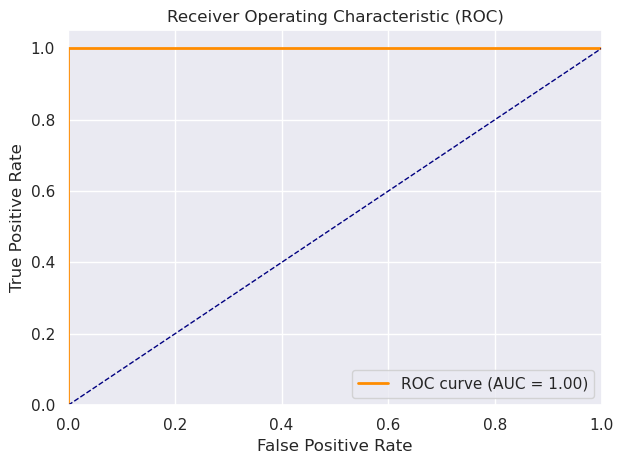

In [29]:
with torch.no_grad():
    probs = model(lowX_test)  # output is already sigmoid if using nn.BCELoss()

# Convert tensors to NumPy
y_true = lowy_test.view(-1).cpu().numpy()
y_scores = probs.view(-1).cpu().numpy()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## High-level

In [37]:
class ANN(nn.Module):
    def __init__(self, input_dim):
        super(ANN, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(50),
            nn.Linear(100, 50),
            nn.ReLU(25),
            nn.Linear(50, 20),
            nn.ReLU(20),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )
    
    def forward(self, x):
        return self.sequential(x)

In [38]:
model = ANN(input_dim=highX_train.size(1))

Loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [39]:
train_data = TensorDataset(highX_train, highy_train)
train_loader = DataLoader(train_data, batch_size=69, shuffle=True)

In [40]:
torch._dynamo.config.suppress_errors = True

# Train neural network
epochs = 350
for epoch in range(epochs):  
    for batch_idx, (data, target) in enumerate(train_loader):       
        optimizer.zero_grad()       
        output = model(data)     
        loss = Loss(output, target)
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch+1, "\tLoss:", loss.item())

Epoch: 1 	Loss: 0.6960613131523132
Epoch: 2 	Loss: 0.7145004868507385
Epoch: 3 	Loss: 0.6843379735946655
Epoch: 4 	Loss: 0.6820650100708008
Epoch: 5 	Loss: 0.6760300993919373
Epoch: 6 	Loss: 0.6624782681465149
Epoch: 7 	Loss: 0.6849314570426941
Epoch: 8 	Loss: 0.6598871946334839
Epoch: 9 	Loss: 0.6642621159553528
Epoch: 10 	Loss: 0.7029263973236084
Epoch: 11 	Loss: 0.6582236289978027
Epoch: 12 	Loss: 0.6810938715934753
Epoch: 13 	Loss: 0.6924938559532166
Epoch: 14 	Loss: 0.6500049233436584
Epoch: 15 	Loss: 0.6982803344726562
Epoch: 16 	Loss: 0.6851823925971985
Epoch: 17 	Loss: 0.6499917507171631
Epoch: 18 	Loss: 0.6545505523681641
Epoch: 19 	Loss: 0.6867929697036743
Epoch: 20 	Loss: 0.654496967792511
Epoch: 21 	Loss: 0.6232868432998657
Epoch: 22 	Loss: 0.6556910872459412
Epoch: 23 	Loss: 0.6638057827949524
Epoch: 24 	Loss: 0.6155306696891785
Epoch: 25 	Loss: 0.6469528675079346
Epoch: 26 	Loss: 0.6727405786514282
Epoch: 27 	Loss: 0.6630281209945679
Epoch: 28 	Loss: 0.6334726214408875
Ep

In [41]:
# Evaluate neural network
with torch.no_grad():
    output = model(highX_test) # Drives x_test to the network 
    test_loss = Loss(output, highy_test)
    preds = torch.sigmoid(output)
    test_accuracy = (preds.round().view(-1) == highy_test.view(-1)).float().mean()

In [42]:
output

tensor([[ 0.2216],
        [ 1.3339],
        [ 0.8359],
        ...,
        [ 1.3339],
        [-1.2842],
        [-0.0587]])

In [43]:
print(f"Test Loss:{test_loss.item()}\tTest Accuracy:{test_accuracy.item():.2f}")

Test Loss:0.6143401861190796	Test Accuracy:0.69


### ROC curve

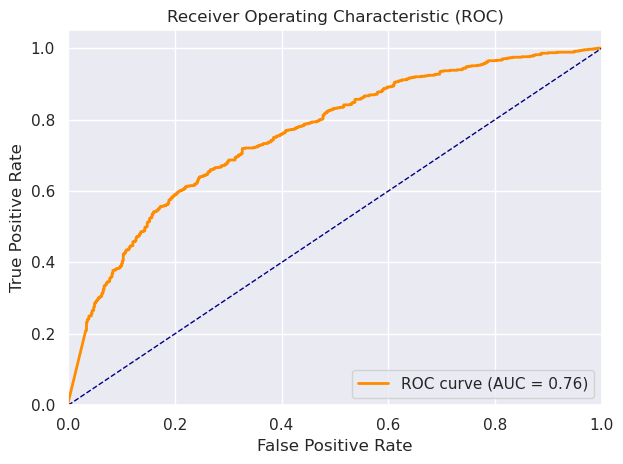

In [39]:
with torch.no_grad():
    probs = model(highX_test)

# Convert tensors to NumPy
y_true = highy_test.view(-1).cpu().numpy()
y_scores = probs.view(-1).cpu().numpy()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scikit-learn Classifiers

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score

In [41]:
scaler = StandardScaler()
lowX_train = scaler.fit_transform(lowX_train)
lowX_test = scaler.transform(lowX_test)
highX_train = scaler.fit_transform(highX_train)
highX_test = scaler.transform(highX_test)

### Random Forest

In [42]:
#for llq
forest_l = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=100, min_samples_split=5,  min_samples_leaf=1, max_features='sqrt', random_state=42)
forest_l.fit(lowX_train, lowy_train)

#for hlq
forest_h = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=100, min_samples_split=5,  min_samples_leaf=1, max_features='sqrt', random_state=42)
forest_h.fit(highX_train, highy_train)

/run/media/burpsploit/Crucial_M2/ml/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/run/media/burpsploit/Crucial_M2/ml/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(criterion='entropy', max_depth=100, min_samples_split=5,
                       n_estimators=300, random_state=42)

In [43]:
forest_l_pred = forest_l.predict(lowX_test)
forest_h_pred = forest_h.predict(highX_test)

#### Confusion matrix

In [44]:
cm_low_rfc = confusion_matrix(lowy_test, forest_l_pred)
accuracy_low_rfc = accuracy_score(lowy_test, forest_l_pred)

print(f"The confusion matrix for low level quantities, using the Random Forest classifier is:\n{cm_low_rfc}")
print(f"The accuracy for low level quantities, using the Random Forest classifier is: {accuracy_low_rfc}\n")

cm_high_rfc = confusion_matrix(highy_test, forest_h_pred)
accuracy_high_rfc = accuracy_score(highy_test, forest_h_pred)

print(f"The confusion matrix for high level quantities, using the Random Forest classifier is:\n{cm_high_rfc}")
print(f"The accuracy for high level quantities, using the Random Forest classifier is: {accuracy_high_rfc}\n")

The confusion matrix for low level quantities, using the Random Forest classifier is:
[[740   0]
 [  0 784]]
The accuracy for low level quantities, using the Random Forest classifier is: 1.0

The confusion matrix for high level quantities, using the Random Forest classifier is:
[[429 239]
 [179 533]]
The accuracy for high level quantities, using the Random Forest classifier is: 0.6971014492753623



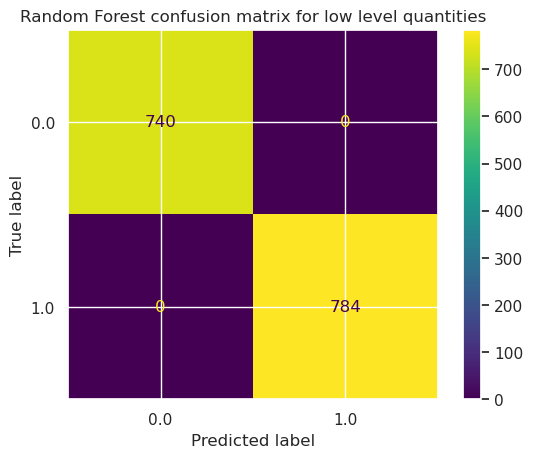

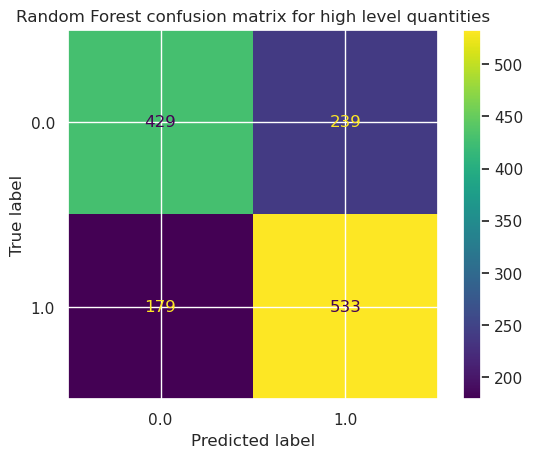

In [45]:
#for low level quantities
disp_low = ConfusionMatrixDisplay(confusion_matrix=cm_low_rfc, display_labels=forest_l.classes_)
disp_low.plot()
plt.title("Random Forest confusion matrix for low level quantities")

#for low level quantities
disp_high = ConfusionMatrixDisplay(confusion_matrix=cm_high_rfc, display_labels=forest_h.classes_)
disp_high.plot()
plt.title("Random Forest confusion matrix for high level quantities")

plt.show()

### Logistic Regression

In [46]:
#for llq
log_l = LogisticRegression(max_iter=400, penalty='l2',C=0.1,solver='newton-cholesky',tol=1e-4,random_state=42)
log_l.fit(lowX_train, lowy_train)

#for hlq
log_h = LogisticRegression(max_iter=400, penalty='l2',C=0.1,solver='newton-cholesky',tol=1e-4, random_state=42)
log_h.fit(highX_train, highy_train)

/run/media/burpsploit/Crucial_M2/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/run/media/burpsploit/Crucial_M2/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.1, max_iter=400, random_state=42,
                   solver='newton-cholesky')

In [47]:
log_l_pred = log_l.predict(lowX_test)
log_h_pred = log_h.predict(highX_test)

#### Confusion matrix

In [48]:
cm_low_log = confusion_matrix(lowy_test, log_l_pred)
accuracy_low_log = accuracy_score(lowy_test, log_l_pred)

print(f"The confusion matrix for low level quantities, using the Logistic Regression is:\n{cm_low_log}")
print(f"The accuracy for low level quantities, using the Logistic Regression is: {accuracy_low_log}\n")

cm_high_log = confusion_matrix(highy_test, log_h_pred)
accuracy_high_log = accuracy_score(highy_test, log_h_pred)

print(f"The confusion matrix for high level quantities, using the Logistic Regression is:\n{cm_high_log}")
print(f"The accuracy for high level quantities, using the Logistic Regression is: {accuracy_high_log}\n")

The confusion matrix for low level quantities, using the Logistic Regression is:
[[740   0]
 [  0 784]]
The accuracy for low level quantities, using the Logistic Regression is: 1.0

The confusion matrix for high level quantities, using the Logistic Regression is:
[[306 362]
 [130 582]]
The accuracy for high level quantities, using the Logistic Regression is: 0.6434782608695652



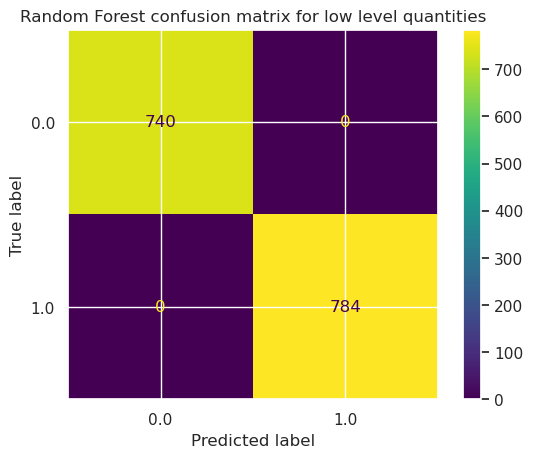

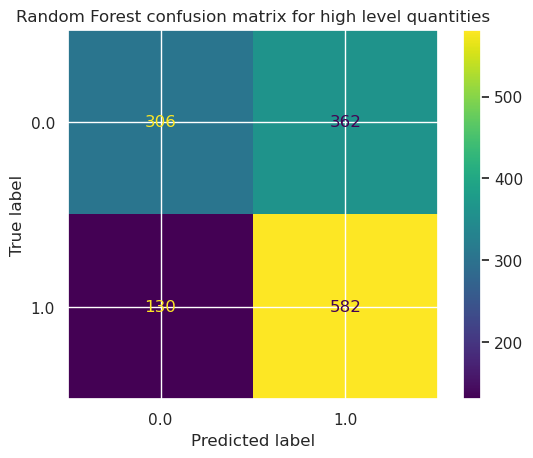

In [49]:
#for low level quantities
disp_low = ConfusionMatrixDisplay(confusion_matrix=cm_low_log, display_labels=log_l.classes_)
disp_low.plot()
plt.title("Random Forest confusion matrix for low level quantities")

#for low level quantities
disp_high = ConfusionMatrixDisplay(confusion_matrix=cm_high_log, display_labels=log_h.classes_)
disp_high.plot()
plt.title("Random Forest confusion matrix for high level quantities")

plt.show()